<a href="https://colab.research.google.com/github/DataMinati/Super-Notebooks-1K/blob/main/Baby_Names_Gender_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
url = 'https://raw.githubusercontent.com/MainakRepositor/Datasets-/master/baby_names.csv'
df = pd.read_csv(url,error_bad_lines=False)
df.head()

,Unnamed: 0,State,Sex,Year,Name,Count
0,0,GA,F,1910,Mary,841
1,1,GA,F,1910,Annie,553
2,2,GA,F,1910,Mattie,320
3,3,GA,F,1910,Ruby,279
4,4,GA,F,1910,Willie,275


In [3]:
all_categories = ['F', 'M']
category_lines = {"F" : df.Name[df.Sex == 'F'].tolist(), "M" : df.Name[df.Sex == 'M'].tolist()}
n_categories = 2

import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [4]:
## Creating the Model
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [5]:
letterToIndex("n")

13

In [6]:
letterToTensor("n")

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [7]:
lineToTensor("name"), lineToTensor("name").size()

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0.,

In [8]:
## Creating Model Arch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        # in linear Layer :  Input @ linear_layer shape
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
x = torch.zeros(2,3)
x2 = torch.ones(2,3)

torch.cat((x, x2), dim=0), torch.cat((x, x2), dim=1)

(tensor([[0., 0., 0.],
         [0., 0., 0.],
         [1., 1., 1.],
         [1., 1., 1.]]), tensor([[0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1., 1.]]))

In [10]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

In [11]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-0.7960, -0.5999]], grad_fn=<LogSoftmaxBackward>)


In [12]:
# Training
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('M', 1)


In [13]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = F / line = Lorie
category = F / line = Virginia
category = M / line = Ralph
category = F / line = Emmy
category = M / line = Brandon
category = M / line = Cedrick
category = F / line = Lena
category = M / line = Wayne
category = M / line = Stuart
category = M / line = Walter


In [14]:
criterion = nn.NLLLoss()

In [15]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        # this method doc : https://pytorch.org/docs/stable/generated/torch.Tensor.add.html#torch.Tensor.add

    return output, loss.item()

In [16]:
import time
import math

n_iters = 2000000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 0% (0m 5s) 0.5897 Wendy / F ✓
10000 0% (0m 9s) 0.5681 Aubrey / M ✓
15000 0% (0m 14s) 0.6040 Malcolm / M ✓
20000 1% (0m 19s) 0.5665 Murry / M ✓
25000 1% (0m 24s) 0.3806 Evonne / F ✓
30000 1% (0m 29s) 0.2895 Randy / M ✓
35000 1% (0m 33s) 0.1267 Karl / M ✓
40000 2% (0m 38s) 0.1903 Deshawn / M ✓
45000 2% (0m 43s) 0.0612 Brad / M ✓
50000 2% (0m 47s) 0.2320 Darnell / M ✓
55000 2% (0m 52s) 0.0668 Dameon / M ✓
60000 3% (0m 57s) 0.1240 Raymond / M ✓
65000 3% (1m 1s) 0.2327 Edgar / M ✓
70000 3% (1m 6s) 0.0236 Nita / F ✓
75000 3% (1m 11s) 0.0162 Jayda / F ✓
80000 4% (1m 15s) 0.3509 Emanuel / M ✓
85000 4% (1m 20s) 0.3410 Kelsi / F ✓
90000 4% (1m 25s) 0.1906 Johnnie / F ✓
95000 4% (1m 29s) 0.2921 Abygail / F ✓
100000 5% (1m 34s) 0.0202 Lisa / F ✓
105000 5% (1m 39s) 0.8323 May / M ✗ (F)
110000 5% (1m 43s) 0.1851 Jadarius / M ✓
115000 5% (1m 48s) 0.5926 Christin / F ✓
120000 6% (1m 53s) 0.0589 Brenton / M ✓
125000 6% (1m 57s) 0.0045 Malinda / F ✓
130000 6% (2m 2s) 0.0242 Della / F ✓
135000 6% (2

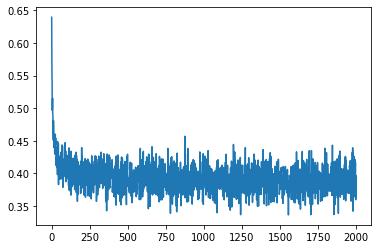

In [17]:
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

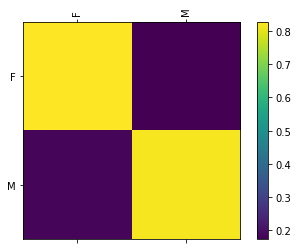

In [18]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()


In [19]:
def predict(input_line, n_predictions=2):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        print(output)
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Mohammad')
predict('Masoud')
predict("Kate")


> Dovesky
tensor([[-0.9058, -0.5179]])
(-0.52) M
(-0.91) F

> Jackson
tensor([[-4.1664, -0.0156]])
(-0.02) M
(-4.17) F

> Satoshi
tensor([[-0.0933, -2.4180]])
(-0.09) F
(-2.42) M

> Mohammad
tensor([[-2.9330, -0.0547]])
(-0.05) M
(-2.93) F

> Masoud
tensor([[-4.4782, -0.0114]])
(-0.01) M
(-4.48) F

> Kate
tensor([[-0.6928, -0.6935]])
(-0.69) F
(-0.69) M
